# Install and import dependencies

Load dependencies required

In [2]:
# python packages
from dataclasses import dataclass
import os
import os.path
import random
import re
import shutil
import typing
import urllib.request

# third-party packages
import keras
import keras.callbacks
import keras.layers
import keras.losses
import keras.optimizers
import keras.regularizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import tensorflow as tf
import tqdm

# Dataset

## Download the data

The dataset is downloaded, if not already present, and then unzipped in the local path.

In [3]:
@dataclass
class DatasetConfig:
    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
    zip = os.path.join(os.getcwd(), "dependency_treebank.zip")
    folder = os.path.join(os.getcwd(), "dependency_treebank")


ds_config = DatasetConfig()

In [11]:
def download_dataset(url: str, zip: str, folder: str) -> None:
    """Download and unzip the dataset from the url if not already downloaded
    Args:
        url (str): url of the dataset
        zip (str): zip name of the downloaded file
        folder (str): folder name contained in the zipped file
    """
    if not os.path.isdir(folder):
        if not os.path.isfile(zip):
            with urllib.request.urlopen(url) as res, open(zip, "wb") as f:
                print(f"Downloading from {url}")
                shutil.copyfileobj(res, f)
        else:
            print(f"Zip folder '{zip}' already present")
        shutil.unpack_archive(zip, extract_dir=folder)
        print(f"'{zip}' unzipped in {folder}")
    else:
        print(f"Folder '{folder}' already present")


download_dataset(ds_config.url, ds_config.zip, ds_config.folder)

Zip folder '/content/dependency_treebank.zip' already present
'/content/dependency_treebank.zip' unzipped in /content/dependency_treebank


## Load the data

- Read the data for training (1-100), validation (101-150) and test (151-199)

The function to process files has a parameter (*remove_punctuation*) to choose whether to remove punctuations or not. 

In the first case, the regex is applied on tags instead of texts, in this way the regex is simpler (many punctuations have the same tag).

In [14]:
class DataLoader:
    folder_name: str
    '''"(" and ")" are tagged with the following character
    sequences, respectively: "-RRB-" and "-LRB-"'''
    PUNCTUATIONS = r"(-RRB-)|(-LRB-)|[\.,\\\"'\-\?\:\!;\[\]\(\)\{\}⟨⟩‒–—―‐…\/⁄‘’“”`]+"

    def __init__(self, folder_name: str):
        self.folder_name = folder_name
        self.prog = re.compile(self.PUNCTUATIONS)

    def __call__(
        self,
        start_i: int,
        end_i: int,
        desc: typing.Optional[str] = None,
        remove_punctuation: bool = True,
    ) -> pd.DataFrame:
        """_summary_

        Args:
            start_file (int): Index of the first file to process
            end_file (int): Index of the last file to process
            dataset_description (typing.Optional[str], optional): Dataset description to show while processing files. Defaults to None.
            remove_punctuation (bool, optional): if the process should remove all punctuations from each file. Defaults to True.

        Returns:
            pd.DataFrame: Dataframe containing the dataset, the first column contains texts, the second one contains tags
        """
        # the dataset dataframe, initially empty
        df = pd.DataFrame(columns=["text", "tags"])

        for i in tqdm.trange(start_i, end_i + 1, desc=f"Reading {desc} data"):
            # zeros contained in the filename
            idx_len = "0" * (4 - len(str(i)))
            # the filename is 'wsj_0xxx.dp'
            data_file = os.path.join(self.folder_name, self.folder_name.rsplit("/", maxsplit=1)[1], f"wsj_{idx_len}{i}.dp")
            # read the file, strip and split into a list of list (the inner one is for each text)
            with open(data_file, "r") as f:
                content = [l.strip().split() for l in f.readlines()]

            # lists of strings to keep track of sentences (occuring after each \n)
            Xrows, yrows = [""], [""]
            i = 0
            for c in content:
                """if the element is empty then it's a new line, so
                the following lines are considered as a new sentence"""
                if len(c) == 0:
                    i += 1
                    Xrows.append("")
                    yrows.append("")
                    continue

                assert len(c) == 3
                if remove_punctuation:
                    # the tag must not match the regex of punctuations
                    if self.prog.fullmatch(c[1]) is None:
                        Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                        yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]
                else:
                    Xrows[i] += (" " if len(Xrows[i]) > 0 else "") + c[0]
                    yrows[i] += (" " if len(yrows[i]) > 0 else "") + c[1]

            new_df = pd.DataFrame.from_dict({"text": Xrows, "tags": yrows})
            df = pd.concat([df, new_df], axis=0, ignore_index=True)
        return df


data_loader = DataLoader(ds_config.folder)
df_train = data_loader(1, 100, desc="train", remove_punctuation=False)
df_val = data_loader(101, 150, desc="validation", remove_punctuation=False)
df_test = data_loader(151, 199, desc="test", remove_punctuation=False)

Reading test data: 100%|██████████| 49/49 [00:00<00:00, 353.56it/s]


## Closer look at datasets

Training

In [12]:
df_train.head()

,text,tags
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ..."
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN ."
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN..."
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ..."


Validation

In [13]:
df_val.head()

,text,tags
0,A House-Senate conference approved major porti...,DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD C...
1,"For the Agency for International Development ,...","IN DT NNP IN NNP NNP , NNS VBD $ CD CD IN JJ N..."
2,The conference approved at least $ 55 million ...,DT NN VBD IN JJS $ CD CD IN JJ NN CC NN NN IN ...
3,The agreement on Poland contrasts with the maj...,DT NN IN NNP VBZ IN DT JJ NNS VBG IN DT VBG JJ...
4,These fiscal pressures are also a factor in sh...,"DT JJ NNS VBP RB DT NN IN VBG DT NNP NN , CC I..."


Test

In [14]:
df_test.head()

,text,tags
0,"Intelogic Trace Inc. , San Antonio , Texas , s...","NNP NNP NNP , NNP NNP , NNP , VBD PRP VBD CD C..."
1,The move boosts Intelogic Chairman Asher Edelm...,DT NN VBZ NNP NNP NNP NNP POS NN TO CD NN IN C...
2,Mr. Ackerman already is seeking to oust Mr. Ed...,NNP NNP RB VBZ VBG TO VB NNP NNP IN NN IN NNP ...
3,The action followed by one day an Intelogic an...,DT NN VBN IN CD NN DT NNP NN IN PRP MD VB DT N...
4,In New York Stock Exchange composite trading y...,"IN NNP NNP NNP NNP JJ NN NN , NNP NNS VBD CD N..."


##Distribution of the tags

In [20]:
def count_tags_in_df(ser: pd.Series, name: str) -> pd.DataFrame:
    """_summary_

    Args:
        ser (pd.Series): _description_
        name (str): _description_

    Returns:
        pd.DataFrame: _description_
    """    
    d_tags = {}

    for tags in ser.str.split(" "):
        for tag in tags:
            d_tags[tag] = d_tags.get(tag, 0) + 1
    return pd.DataFrame.from_records(
        list(d_tags.items()), columns=["tags", f"{name}_counts"]
    )


tags_train = count_tags_in_df(df_train.tags, "train")
tags_val = count_tags_in_df(df_val.tags, "validation")
tags_test = count_tags_in_df(df_test.tags, "test")

In [21]:
tags_all = (
    tags_train.merge(tags_val, how="outer", on="tags")
    .merge(tags_test, how="outer", on="tags", sort=True)
    .fillna(0)
    .convert_dtypes(convert_integer=True)
)

display(tags_all)

,tags,train_counts,validation_counts,test_counts
0,#,1,15,0
1,$,342,173,209
2,'',399,225,70
3,",",2571,1528,787
4,-LRB-,52,50,18
5,-RRB-,55,53,18
6,.,1959,1277,638
7,:,293,214,56
8,CC,1141,758,366
9,CD,1439,1249,858


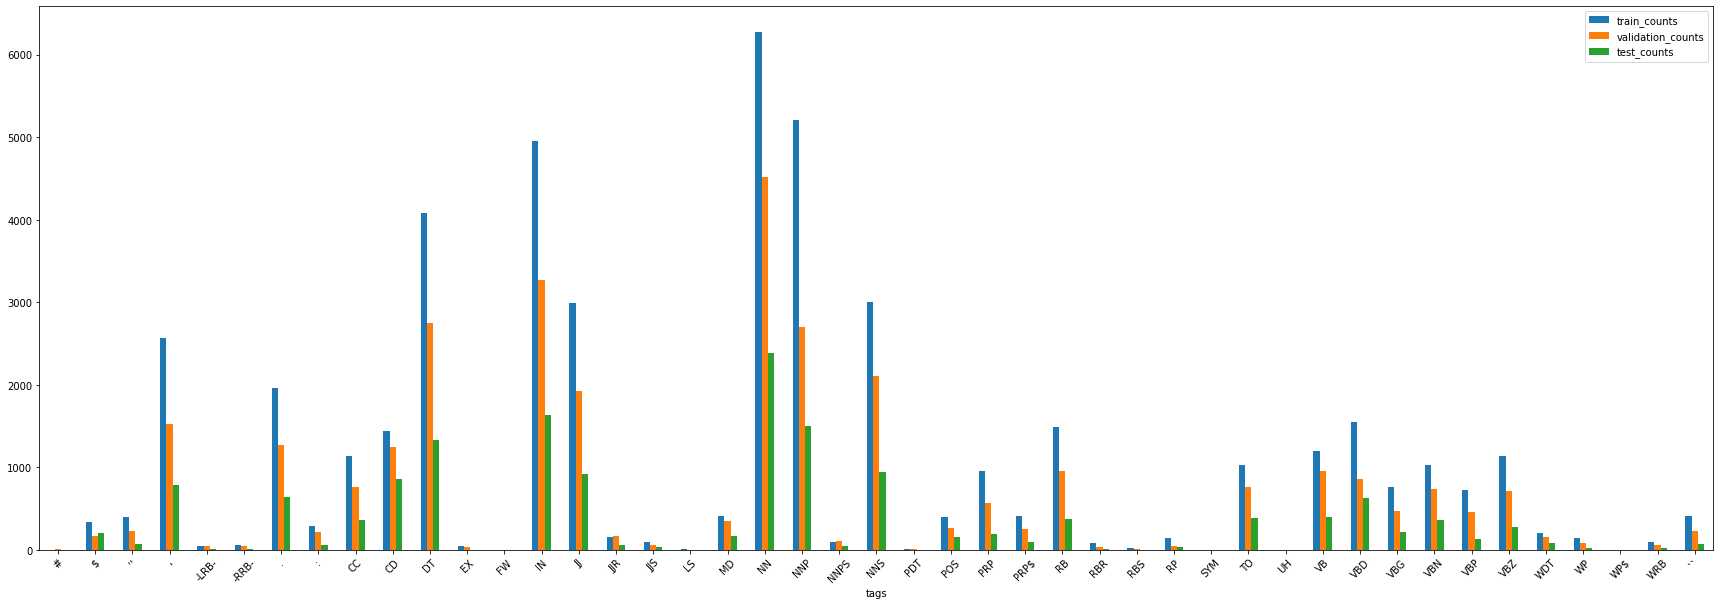

In [22]:
tags_all.plot.bar("tags", rot=45, figsize=(30, 10))
plt.show()

## Text lengths

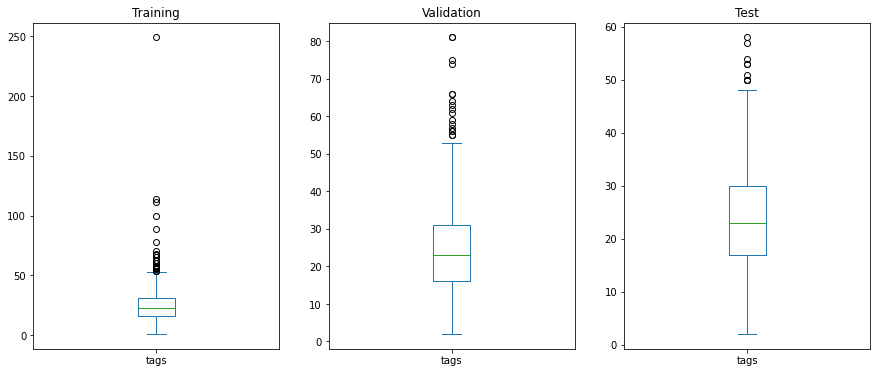

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
faxs = axs.ravel()

df_train["tags"].apply(lambda x: len(x.split(" "))).plot.box(ax=faxs[0], title="Training")
df_val["tags"].apply(lambda x: len(x.split(" "))).plot.box(ax=faxs[1], title="Validation")
df_test["tags"].apply(lambda x: len(x.split(" "))).plot.box(ax=faxs[2], title="Test")

fig.show()

# Model preparation

Model configuration which will be used in the following sections

In [17]:
@dataclass
class ModelConfiguration:
    EMBEDDING_DIM = 300
    MAX_SEQUENCE = 96
    VOCABULARY_SIZE = 15000
    EPOCHS = 50
    SD_RATE = 0.3
    D_RATe = 0.2
    L_REG = 0.2

model_conf = ModelConfiguration()

## Dataframe to dataset

The concatenation of all dataframes are converted to a Tensorflow Dataset.

In [191]:
def df_to_dataset(df: pd.DataFrame, batch_size: int = 32) -> tf.data.Dataset:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        batch_size (int, optional): _description_. Defaults to 32.

    Returns:
        tf.data.Dataset: _description_
    """
    return tf.data.Dataset.from_tensor_slices((df["text"], df["tags"])).batch(
        batch_size
    )


raw_all_ds = df_to_dataset(pd.concat([df_train, df_val, df_test]), 512)

## Tokenization and encoding

### Tokenization

In [192]:
class TokenizeFeatures:
    vocab_size: int
    max_sequence: int
    layer: keras.layers.TextVectorization

    def __init__(
        self, dataset: tf.data.Dataset, vocab_size: int = 50000, max_sequence: int = 64
    ):
        self.vocab_size = vocab_size
        self.max_sequence = max_sequence

        self.layer = keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode="int",
            standardize="lower",
            output_sequence_length=self.max_sequence,
        )

        features_ds = dataset.map(lambda x, _: x)
        features_ds = features_ds.map(
            lambda x: tf.strings.split(x, sep=" ").to_tensor()
        )
        features_ds = features_ds.map(lambda x: tf.expand_dims(x, -1))

        self.layer.adapt(features_ds)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        """_summary_

        Args:
            dataset (tf.data.Dataset): _description_

        Returns:
            tf.data.Dataset: _description_
        """
        return dataset.map(lambda x, y: (self.layer(x), y))

    def get_vocabulary(self) -> typing.List[str]:
        """_summary_

        Returns:
            typing.List[str]: _description_
        """
        return self.layer.get_vocabulary()


tokenize_features = TokenizeFeatures(
    raw_all_ds, model_conf.VOCABULARY_SIZE, model_conf.MAX_SEQUENCE
)

### Encode of labels

In [193]:
class EncodeLabels:
    max_sequence: int
    layer: keras.layers.StringLookup

    def __init__(self, dataset: tf.data.Dataset, max_sequence: int = 50000):
        self.max_sequence = max_sequence
        self.layer = keras.layers.StringLookup(output_mode="int")

        label_ds = dataset.map(lambda _, y: y)
        label_ds = label_ds.map(lambda y: tf.strings.split(y, sep=" ").to_tensor())
        label_ds = label_ds.map(lambda y: y[..., : self.max_sequence])
        label_ds = label_ds.map(
            lambda y: tf.concat(
                [y, tf.fill((tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), "")],
                -1,
            )
        )

        self.layer.adapt(label_ds)

    def __call__(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        """_summary_

        Args:
            dataset (tf.data.Dataset): _description_

        Returns:
            tf.data.Dataset: _description_
        """
        ds = dataset.map(lambda x, y: (x, tf.strings.split(y, sep=" ").to_tensor()))
        ds = ds.map(lambda x, y: (x, y[..., : self.max_sequence]))
        # TODO CHANGE IN MULTIPLE LINES
        ds = ds.map(
            lambda x, y: (
                x,
                tf.concat(
                    [
                        y,
                        tf.fill(
                            (tf.shape(y)[0], self.max_sequence - tf.shape(y)[-1]), ""
                        ),
                    ],
                    -1,
                ),
            )
        )
        ds = ds.map(lambda x, y: (x, self.layer(y)))
        return ds

    def get_vocabulary(self) -> typing.List[str]:
        """_summary_

        Returns:
            typing.List[str]: _description_
        """
        return self.layer.get_vocabulary()

    def get_vocabulary_size(self) -> int:
        """_summary_

        Returns:
            int: _description_
        """
        return self.layer.vocabulary_size()


encode_labels = EncodeLabels(raw_all_ds, model_conf.MAX_SEQUENCE)

### Decode of labels

This layer is used after inference to decode integers back to tags. It uses the vocabulary of the encoding

In [194]:
class DecodeLabels:
    layer: keras.layers.StringLookup

    def __init__(self, vocabulary: typing.List[str]):
        self.layer = keras.layers.StringLookup(
            output_mode="int", vocabulary=vocabulary, invert=True
        )

    def __call__(self, ds: np.ndarray, predict=True) -> np.ndarray:
        """_summary_

        Args:
            ds (np.ndarray): _description_
            predict (bool, optional): _description_. Defaults to True.

        Returns:
            np.ndarray: _description_
        """        
        if predict:
            ds = tf.math.argmax(ds, axis=-1)
        ds = self.layer(ds).numpy()
        # ds = tf.strings.reduce_join(ds, axis=-1, separator=" ")
        # ds = tf.strings.strip(ds)
        return ds.astype(str)


decode_labels = DecodeLabels(encode_labels.get_vocabulary())

## Encode and tokenize datasets

In [195]:
def prepare_data(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        batch_size (int): _description_

    Returns:
        tf.data.Dataset: _description_
    """    
    ds = df_to_dataset(df, batch_size)
    ds = encode_labels(ds)
    return tokenize_features(ds).prefetch(tf.data.AUTOTUNE)


train_ds = prepare_data(df_train, 64)
val_ds = prepare_data(df_val, 512)
test_ds = prepare_data(df_test, 512)

## Embedding layer

The GloVE embedding is used. In particular the one downloaded comes from *Wikipedia 2014 + Gigaword 5*, it contains 6B tokens and 400K vocab.

Weights are available in different dimensions (50d, 100d, 200d and 300d), the one used in this notebook is 300d.

In [9]:
@dataclass
class EmbeddingConfig:
    url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"
    zip = os.path.join(os.getcwd(), "glove.6B.zip")
    folder = os.path.join(os.getcwd(), "glove.6B")


embd_config = EmbeddingConfig()

download_dataset(embd_config.url, embd_config.zip, embd_config.folder)

Zip folder '/content/glove.6B.zip' already present
'/content/glove.6B.zip' unzipped in /content/glove.6B


### Get GloVe vocabulary

In [18]:
def load_glove_embedding(glove_file: str) -> typing.Dict[str, np.ndarray]:
    """_summary_

    Args:
        glove_file (str): _description_

    Returns:
        typing.Dict[str, np.ndarray]: _description_
    """    
    embeddings_index = {}

    with open(glove_file, encoding="utf-8") as f:
        file_content = f.readlines()

    for line in tqdm.tqdm(file_content, desc=f"Loading GloVe"):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs
    return embeddings_index


glove_file = os.path.join(embd_config.folder, f"glove.6B.{model_conf.EMBEDDING_DIM}d.txt")
embeddings_index = load_glove_embedding(glove_file)

print(f"\nFound {len(embeddings_index)} word vectors.")

Loading GloVe: 100%|██████████| 400001/400001 [00:22<00:00, 17433.97it/s]



Found 400001 word vectors.


### Handling of OOV terms

In [197]:
def set_reproducibility(seed: int) -> np.random.Generator:
    """_summary_

    Args:
        seed (int): _description_

    Returns:
        np.random.Generator: _description_
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    return np.random.default_rng(seed)


rng = set_reproducibility(42)

In [198]:
def load_model_embedding(
    vocabulary: typing.List[str],
    embeddings_index: typing.Dict[str, np.ndarray],
    embedding_dim: int,
    rng: np.random.Generator,
) -> np.ndarray:
    """_summary_

    Args:
        vocabulary (typing.List[str]): _description_
        embeddings_index (typing.Dict[str, np.ndarray]): _description_
        embedding_dim (int): _description_
        rng (np.random.Generator): _description_

    Returns:
        np.ndarray: _description_
    """
    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

    for i, word in enumerate(vocabulary):
        """If the embedding can be found on V1, we take that, otherwise
        it's an OOV word and therefore we randomly generate an embedding for it"""
        embedding_vector = embeddings_index.get(word, rng.random((embedding_dim,)))
        assert embedding_vector.size == embedding_dim
        embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_matrix = load_model_embedding(
    tokenize_features.get_vocabulary(), embeddings_index, model_conf.EMBEDDING_DIM, rng
)
print(f"Converted {embedding_matrix.shape[0]} words")

Converted 10949 words


# Models

In [199]:
NUM_CLASSES = encode_labels.get_vocabulary_size()
print(f"Number of classes is: {NUM_CLASSES}")

histories = dict()

Number of classes is: 47


In [200]:
!rm df_model_no_punct.pkl
!rm df_model_punct.pkl

In [201]:
# x = keras.layers.SpatialDropout1D(0.3)(embedded)
# x = keras.layers.Dropout(0.2)(x)
# lstm = keras.layers.LSTM(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(0.02))

## Baseline model

Input -> Embedding -> BiLSTM -> Dense

In [202]:
def create_baseline_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    lstm = keras.layers.LSTM(128, return_sequences=True)
    x = keras.layers.Bidirectional(lstm)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


baseline_model = create_baseline_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
baseline_model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_20 (Embedding)    (None, 96, 300)           3284700   
                                                                 
 bidirectional_25 (Bidirecti  (None, 96, 256)          439296    
 onal)                                                           
                                                                 
 dense_25 (Dense)            (None, 96, 47)            12079     
                                                                 
Total params: 3,736,075
Trainable params: 451,375
Non-trainable params: 3,284,700
_________________________________________________________________


In [203]:
histories["baseline"] = baseline_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 5s 50ms/step - loss: 0.9891 - accuracy: 0.7588 - val_loss: 0.7155 - val_accuracy: 0.8244
Epoch 2/50
31/31 [==============================] - 1s 21ms/step - loss: 0.6510 - accuracy: 0.8399 - val_loss: 0.5898 - val_accuracy: 0.8564
Epoch 3/50
31/31 [==============================] - 3s 25ms/step - loss: 0.5204 - accuracy: 0.8729 - val_loss: 0.4574 - val_accuracy: 0.8847
Epoch 4/50
31/31 [==============================] - 4s 81ms/step - loss: 0.3982 - accuracy: 0.8988 - val_loss: 0.3566 - val_accuracy: 0.9077
Epoch 5/50
31/31 [==============================] - 1s 21ms/step - loss: 0.3127 - accuracy: 0.9212 - val_loss: 0.2905 - val_accuracy: 0.9271
Epoch 6/50
31/31 [==============================] - 1s 21ms/step - loss: 0.2564 - accuracy: 0.9371 - val_loss: 0.2463 - val_accuracy: 0.9383
Epoch 7/50
31/31 [==============================] - 2s 64ms/step - loss: 0.2184 - accuracy: 0.9458 - val_loss: 0.2158 - val_accuracy: 0.9444
Epoch 8/50
31

## Model with a Gated Recurrent Units (GRU) Layer

Input -> Embedding -> BiGRU -> Dense

In [204]:
def create_gru_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    x = keras.layers.SpatialDropout1D(model_conf.SD_RATE)(x)

    gru = keras.layers.GRU(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(model_conf.L_RATE))
    x = keras.layers.Bidirectional(gru)(x)

    x = keras.layers.Dropout(model_conf.D_RATE)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


gru_model = create_gru_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
gru_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_21 (Embedding)    (None, 96, 300)           3284700   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 96, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_26 (Bidirecti  (None, 96, 256)          330240    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 96, 256)           0         
                                                                 
 dense_26 (Dense)            (None, 96, 47)            120

In [205]:
histories["gru"] = gru_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 9s 151ms/step - loss: 4.4919 - accuracy: 0.7631 - val_loss: 2.7894 - val_accuracy: 0.8374
Epoch 2/50
31/31 [==============================] - 1s 20ms/step - loss: 1.9922 - accuracy: 0.8542 - val_loss: 1.3332 - val_accuracy: 0.8781
Epoch 3/50
31/31 [==============================] - 2s 21ms/step - loss: 1.0037 - accuracy: 0.8865 - val_loss: 0.7227 - val_accuracy: 0.9029
Epoch 4/50
31/31 [==============================] - 4s 126ms/step - loss: 0.5838 - accuracy: 0.9090 - val_loss: 0.4579 - val_accuracy: 0.9202
Epoch 5/50
31/31 [==============================] - 1s 21ms/step - loss: 0.3957 - accuracy: 0.9236 - val_loss: 0.3350 - val_accuracy: 0.9296
Epoch 6/50
31/31 [==============================] - 2s 63ms/step - loss: 0.3049 - accuracy: 0.9318 - val_loss: 0.2719 - val_accuracy: 0.9360
Epoch 7/50
31/31 [==============================] - 2s 62ms/step - loss: 0.2552 - accuracy: 0.9385 - val_loss: 0.2354 - val_accuracy: 0.9412
Epoch 8/50


## Model with two Bidirectional Long Short-Term Memory (LSTM) Layers

Input -> Embedding -> BiLSTM -> BiLSTM -> Dense

In [206]:
def create_dual_lstm_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    x = keras.layers.SpatialDropout1D(model_conf.SD_RATE)(x)

    for _ in range(2):
        lstm = keras.layers.LSTM(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(model_conf.L_RATE))
        # lstm = keras.layers.LSTM(128, return_sequences=True)
        x = keras.layers.Bidirectional(lstm)(x)
        x = keras.layers.Dropout(model_conf.D_RATE)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


dual_lstm_model = create_dual_lstm_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
dual_lstm_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_22 (Embedding)    (None, 96, 300)           3284700   
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 96, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_27 (Bidirecti  (None, 96, 256)          439296    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 96, 256)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 96, 256)          394

In [ ]:
histories["dual_lstm"] = dual_lstm_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

Epoch 1/50
31/31 [==============================] - 14s 272ms/step - loss: 7.5546 - accuracy: 0.7490 - val_loss: 4.2251 - val_accuracy: 0.7940
Epoch 2/50
31/31 [==============================] - 2s 79ms/step - loss: 2.8380 - accuracy: 0.7963 - val_loss: 1.7957 - val_accuracy: 0.8079
Epoch 3/50
31/31 [==============================] - 4s 125ms/step - loss: 1.3411 - accuracy: 0.8122 - val_loss: 0.9709 - val_accuracy: 0.8335
Epoch 4/50
31/31 [==============================] - 2s 73ms/step - loss: 0.7958 - accuracy: 0.8426 - val_loss: 0.6215 - val_accuracy: 0.8699
Epoch 5/50
31/31 [==============================] - 4s 103ms/step - loss: 0.5374 - accuracy: 0.8760 - val_loss: 0.4362 - val_accuracy: 0.8945
Epoch 6/50
31/31 [==============================] - 2s 72ms/step - loss: 0.3998 - accuracy: 0.8996 - val_loss: 0.3361 - val_accuracy: 0.9122
Epoch 7/50
31/31 [==============================] - 6s 167ms/step - loss: 0.3220 - accuracy: 0.9141 - val_loss: 0.2777 - val_accuracy: 0.9257
Epoch 8/

## Model with an additional Dense Layer

Input -> Embedding -> BiLSTM -> Dense -> Dense

In [ ]:
def create_dual_dense_model(
    max_sequence: int, num_classes: int, embedding_matrix: np.ndarray
):
    inputs = keras.layers.Input((model_conf.MAX_SEQUENCE,), dtype="int64")

    x = keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )(inputs)

    x = keras.layers.SpatialDropout1D(model_conf.SD_RATE)(x)
    
    lstm = keras.layers.LSTM(128, return_sequences=True, recurrent_regularizer=keras.regularizers.l2(model_conf.L_RATE))
    x = keras.layers.Bidirectional(lstm)(x)
    x = keras.layers.Dropout(model_conf.D_RATE)(x)

    x = keras.layers.TimeDistributed(keras.layers.Dense(num_classes, activation="relu"))(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


dual_dense_model = create_dual_dense_model(
    model_conf.MAX_SEQUENCE, NUM_CLASSES, embedding_matrix
)
dual_dense_model.summary()

In [ ]:
histories["dual_dense"] = dual_dense_model.fit(train_ds, validation_data=val_ds, epochs=model_conf.EPOCHS)

# Evaluation

## Training trend analysis

Let's see how the training of the networks went. 

This is useful in order to determine whether the networks overfitted or not. We could have potentially set up a so-called "callback" and, in particular, an "EarlyStopping" callback, to make sure that the training stops as soon as the chosen metric in the chosen set stops improving (up to a certain tolerance) for a certain number of epochs, but training on this small dataset does not take a lot of time anyway.

In [ ]:
def display_histories(histories: typing.Dict[str, keras.callbacks.History]):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    faxs = axs.ravel()

    for i, (name, history) in enumerate(histories.items()):
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]

        # Visualize the behavior of the loss
        x_values = np.arange(1, len(train_loss)+1)
        faxs[i].plot(x_values, train_loss)
        faxs[i].plot(x_values, val_loss)
        faxs[i].set_xticks(np.arange(1, len(train_loss)+1, step=3))

        faxs[i].grid()
        faxs[i].set_title(f"Loss during training ({name.replace('_', ' ').title()})")
        faxs[i].set_xlabel("Epoch")
        faxs[i].legend(["Training", "Validation"])
    fig.show()


display_histories(histories)

We're very close to the best-case scenario. The graphs allow us to determine that the networks have not overfitted and, instead, learned pretty well how to generalize. This also suggests that we could try to increase the number of epochs in order to obtain even better results.

## Dataframes for metrics

In [ ]:
def decode_true_labels(
    ds: tf.data.Dataset,
    decode_labels: DecodeLabels,
    punctuations: typing.Optional[str] = None,
):
    y_true = decode_labels(np.concatenate([y for _, y in ds], axis=0), predict=False)

    if punctuations is not None:
        df_idx = pd.DataFrame(y_true).apply(lambda x: ~x.str.fullmatch(punctuations))
        idx = df_idx.to_numpy().flatten()
        return y_true.flatten()[idx], idx
    return y_true.flatten(), None

In [ ]:
def create_models_dataframe(
    val_ds: tf.data.Dataset,
    test_ds: tf.data.Dataset,
    models: typing.Dict[str, keras.Model],
    decode_labels: DecodeLabels,
    punctuations: typing.Optional[str] = None,
):
    n_models = len(models.keys())
    ds_dict = {"val": val_ds, "test": test_ds}

    df_dict = dict()
    df_dict["name"] = list(models.keys())

    for ds_name, ds in ds_dict.items():
        # Compute true labels for the dataset
        y_true, idx = decode_true_labels(ds, decode_labels, punctuations)

        # Add results to the dictionary later used to build the DataFrame
        df_dict[f"y_{ds_name}_true"] = np.repeat(
            y_true.reshape(1, -1), n_models, axis=0
        ).tolist()

        y_preds = np.zeros((n_models, y_true.size), dtype=object)
        for i, model in enumerate(models.values()):
            # computing predicted labels for the i-th model
            y_pred = decode_labels(model.predict(ds, verbose=2), predict=True).flatten()
            if idx is not None:
                y_pred = y_pred[idx]
            y_preds[i] = y_pred

        df_dict[f"y_{ds_name}_pred"] = y_preds.tolist()

    for v in df_dict.values():
        assert len(v) == 4
    return pd.DataFrame.from_dict(df_dict, orient="columns")

In [ ]:
no_punct_path = os.path.join(os.getcwd(), "df_model_no_punct.pkl")
if os.path.exists(no_punct_path):
    df_no_punct = pd.read_pickle(no_punct_path)
else:
    trained_models = {
        "Baseline": baseline_model,
        "GRU": gru_model,
        "Dual LSTM": dual_lstm_model,
        "Dual Dense": dual_dense_model,
    }
    df_no_punct = create_models_dataframe(
        val_ds, test_ds, trained_models, decode_labels, data_loader.PUNCTUATIONS
    )
    df_no_punct.to_pickle(no_punct_path)

df_no_punct.head()

## Metrics

### Classification report

Checking whether the results on the test set are coherent with the results on the validation set.

At first glance, it could look strange the fact that, even though we excluded the punctuation, some remnants of them can be found in the classification reports above. 

The reason is the following: punctuation has indeed been removed, however, we didn't prevent the model from predicting a punctuation tag (as this would require either changing the model or artificially manipulate the output of the network). Since the model can, sometimes, wrongfully predict a non-punctuation tag as punctuation tag, some rows related to them may occur in the classification report. 

We're sure, though, that the punctuation tags have been removed from the true labels because the support corresponding to punctuation tags is always 0.

In [145]:
def compute_classification_report(y: pd.Series) -> pd.Series:
    print(f"Classification report for the {y['name']} model")
    print("VALIDATION")
    print(sklearn.metrics.classification_report(y["y_val_true"], y["y_val_pred"], zero_division=0))
    print(75 * "-")
    print("TEST")
    print(sklearn.metrics.classification_report(y["y_test_true"], y["y_test_pred"], zero_division=0))
    print(75 * "=")

    cp_val = sklearn.metrics.classification_report(
        y["y_val_true"], y["y_val_pred"], zero_division=0, output_dict=True
    )
    cp_test = sklearn.metrics.classification_report(
        y["y_test_true"], y["y_test_pred"], zero_division=0, output_dict=True
    )
    return pd.Series(
        data={
            "classification_report_val": cp_val,
            "classification_report_test": cp_test,
        }
    )


df_cr_no_punct = df_no_punct.apply(
    lambda x: compute_classification_report(x), axis=1
).rename(index=df_no_punct["name"])

assert isinstance(df_cr_no_punct, pd.DataFrame)

Classification report for the Baseline model
VALIDATION
              precision    recall  f1-score   support

                   1.00      1.00      1.00    301361
           #       0.00      0.00      0.00        15
           $       1.00      0.99      1.00       173
       -LRB-       0.00      0.00      0.00         0
       -RRB-       0.00      0.00      0.00         0
           .       0.00      0.00      0.00         0
          CC       0.98      0.97      0.98       758
          CD       0.91      0.94      0.93      1249
          DT       0.98      0.98      0.98      2754
          EX       0.92      1.00      0.96        34
          FW       0.00      0.00      0.00         2
          IN       0.95      0.95      0.95      3275
          JJ       0.70      0.71      0.71      1924
         JJR       0.79      0.61      0.69       165
         JJS       0.70      0.40      0.51        58
          LS       0.00      0.00      0.00         3
          MD       0.98  

### Confusion matrix

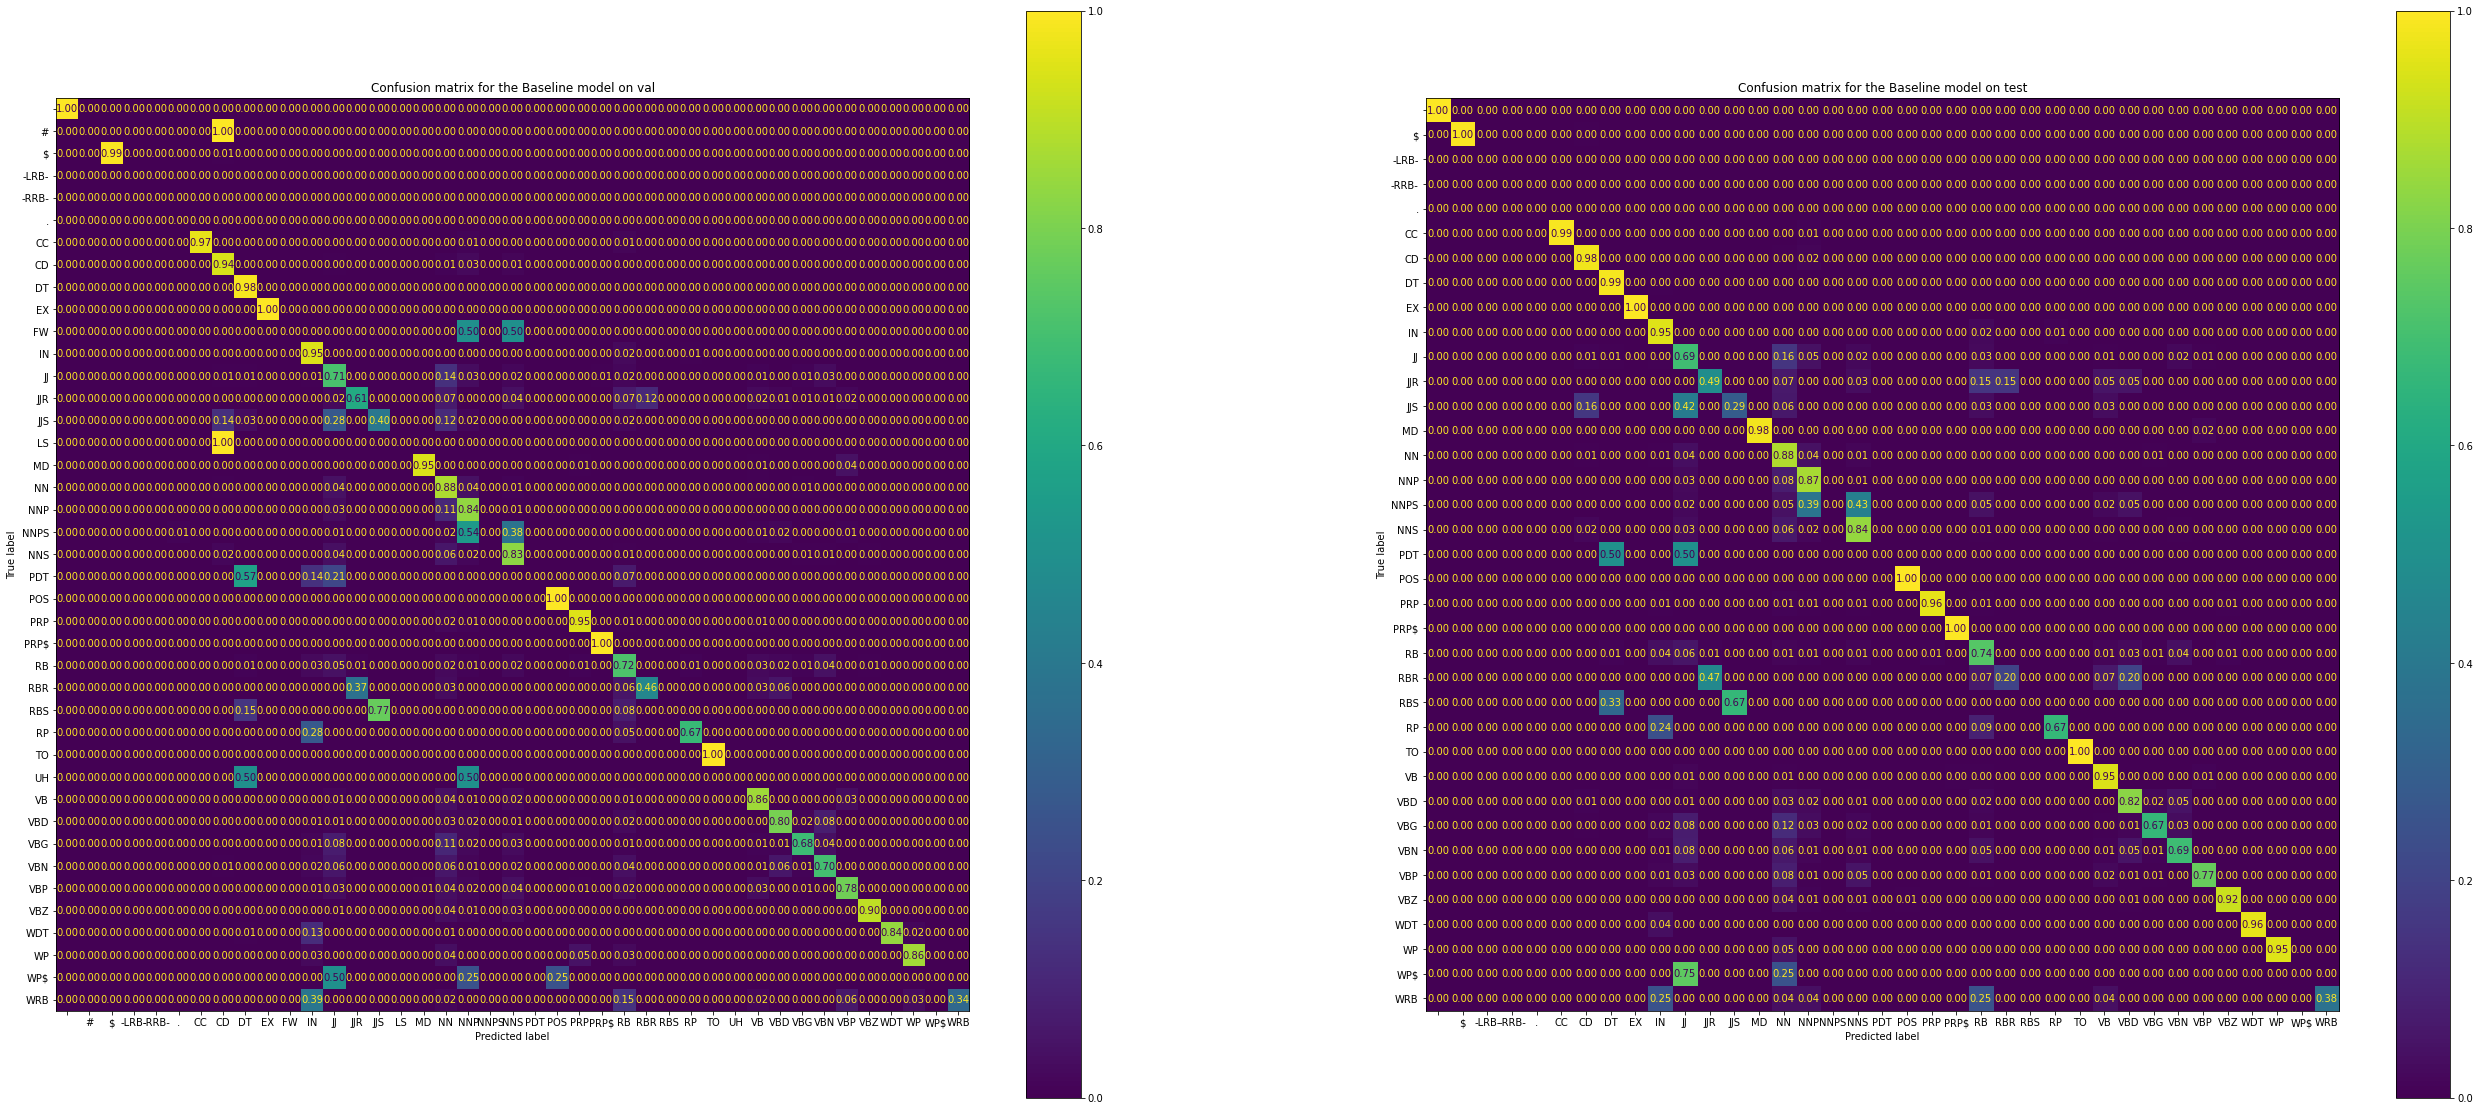

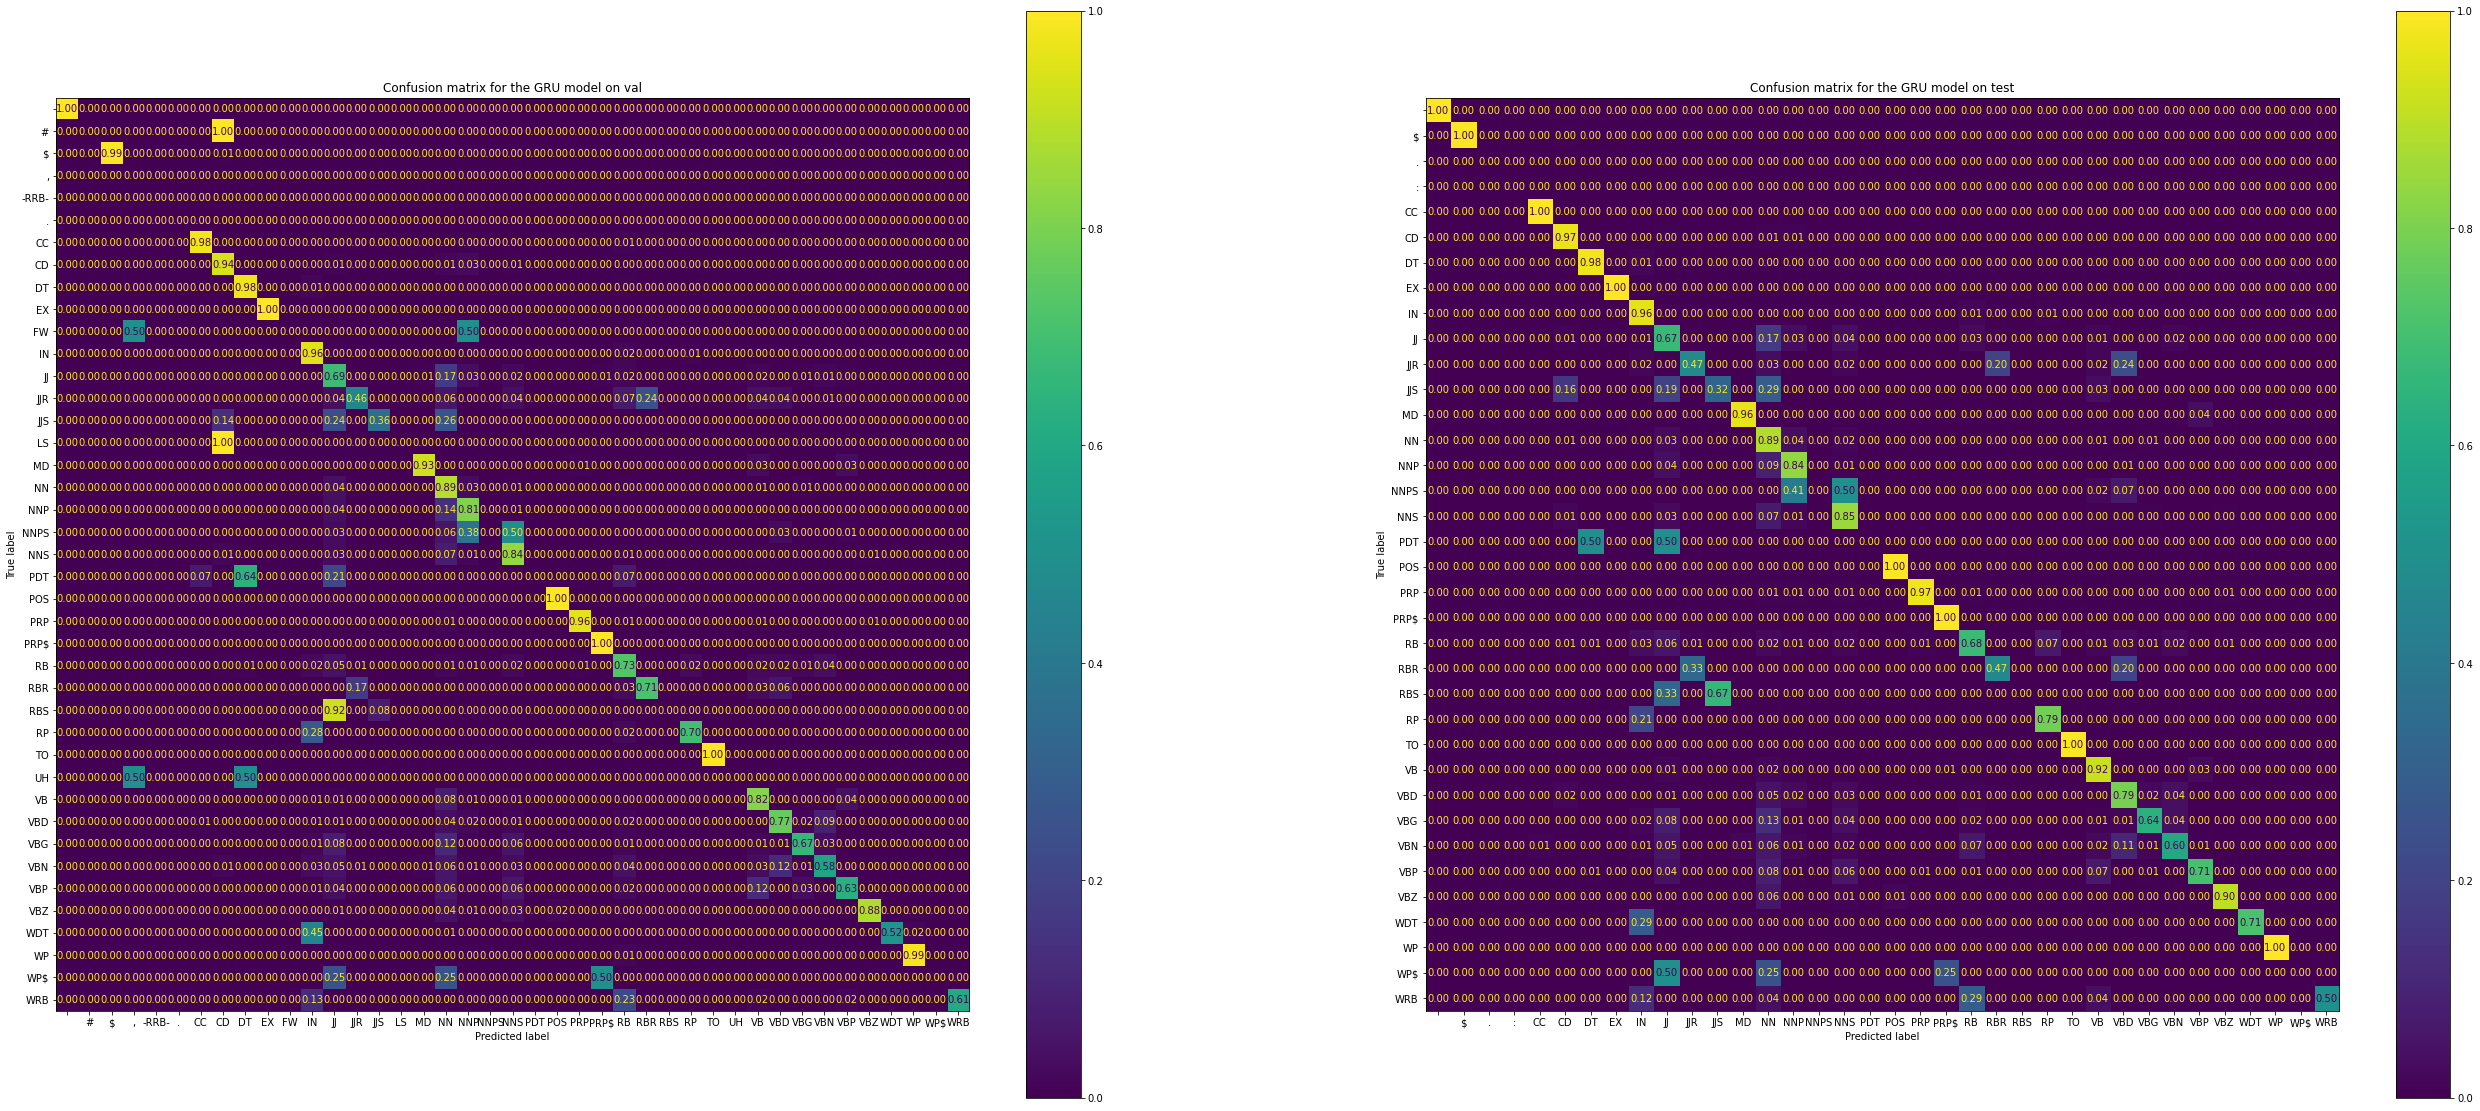

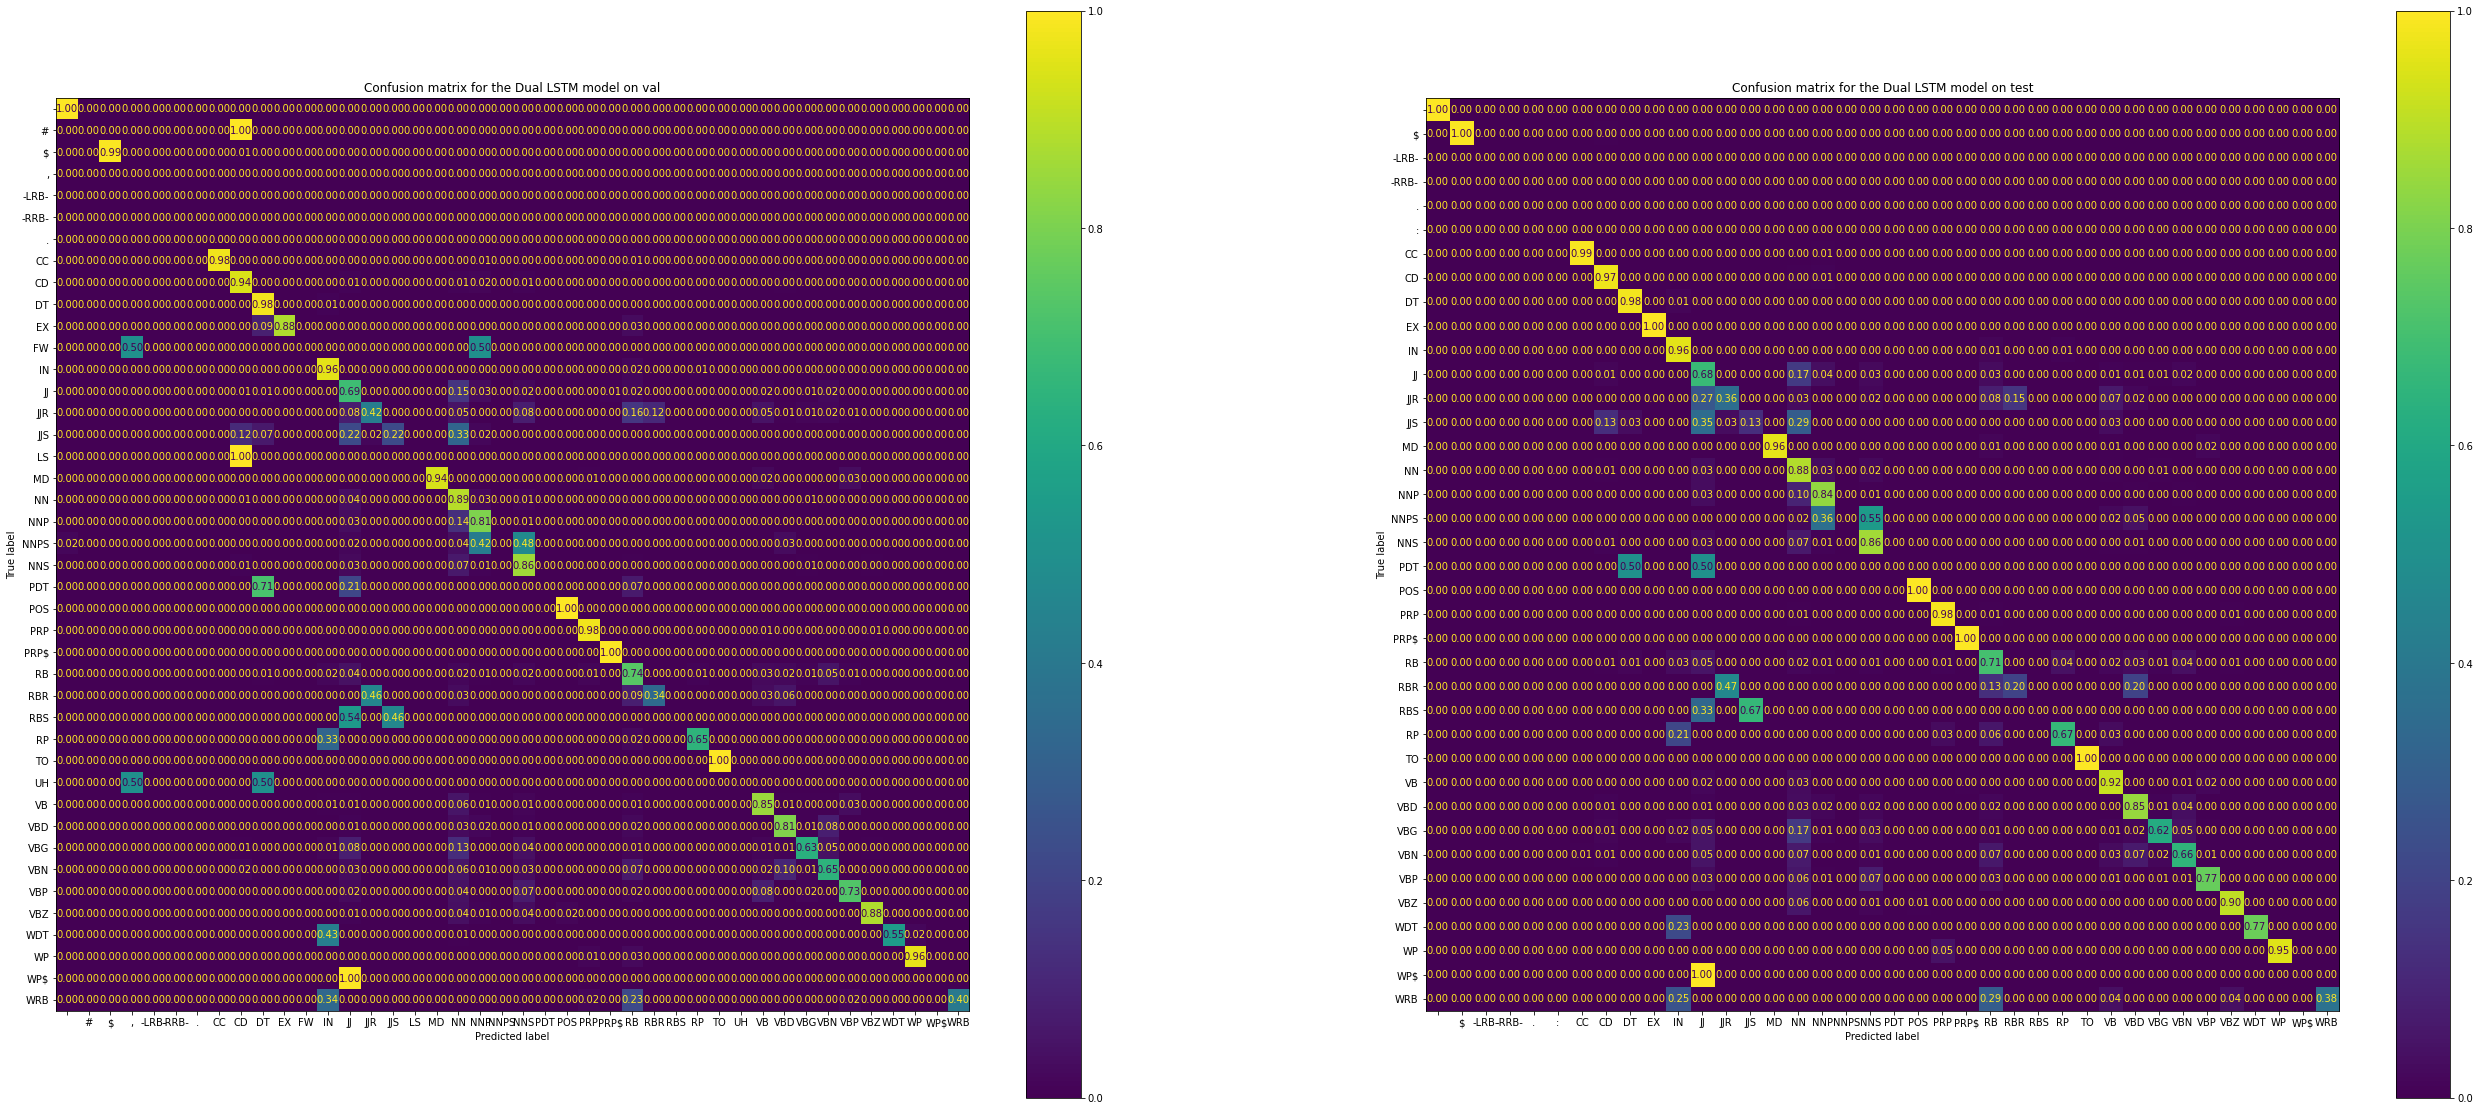

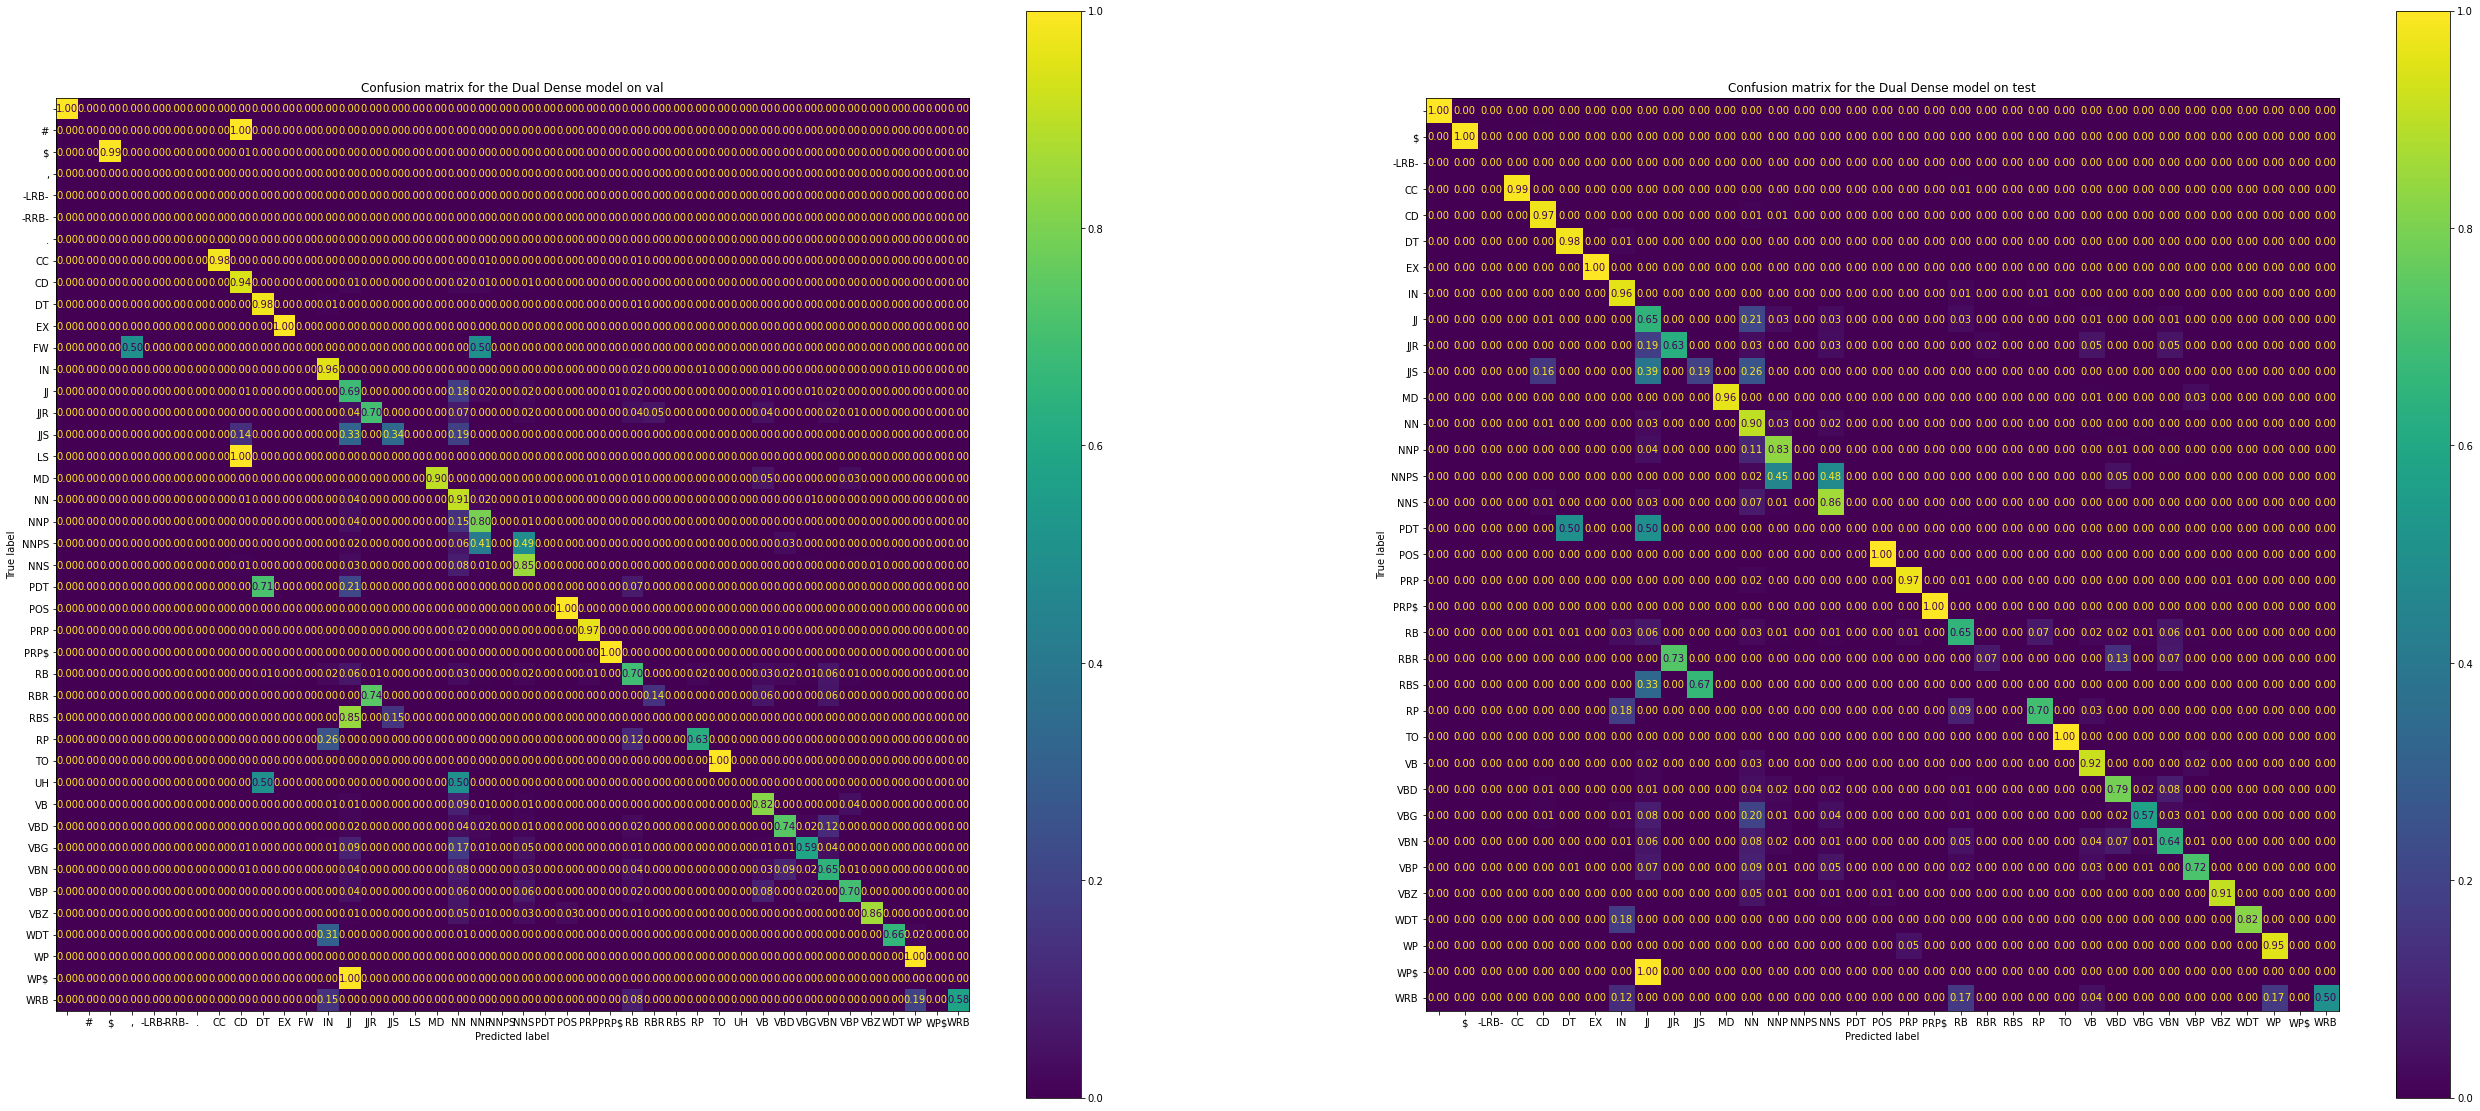

In [146]:
def plot_confusion_matrix(y: pd.Series):
    fig, axs = plt.subplots(1, 2, figsize=(45, 20))
    faxs = axs.ravel()

    for i, column_name in enumerate(["val", "test"]):
        # Validation set
        y_true = y[f"y_{column_name}_true"]
        y_pred = y[f"y_{column_name}_pred"]

        labels = np.unique(np.concatenate([y_true, y_pred]))
        disp = sklearn.metrics.ConfusionMatrixDisplay(
            sklearn.metrics.confusion_matrix(y_true, y_pred, normalize="true"),
            display_labels=labels,
        )
        disp.plot(ax=faxs[i], values_format=".2f")

        faxs[i].set_title(
            f"Confusion matrix for the {y['name']} model on {column_name}"
        )
    fig.show()


_ = df_no_punct.apply(lambda x: plot_confusion_matrix(x), axis=1)

### Histograms of macro averages of precision, recall and f1-score.

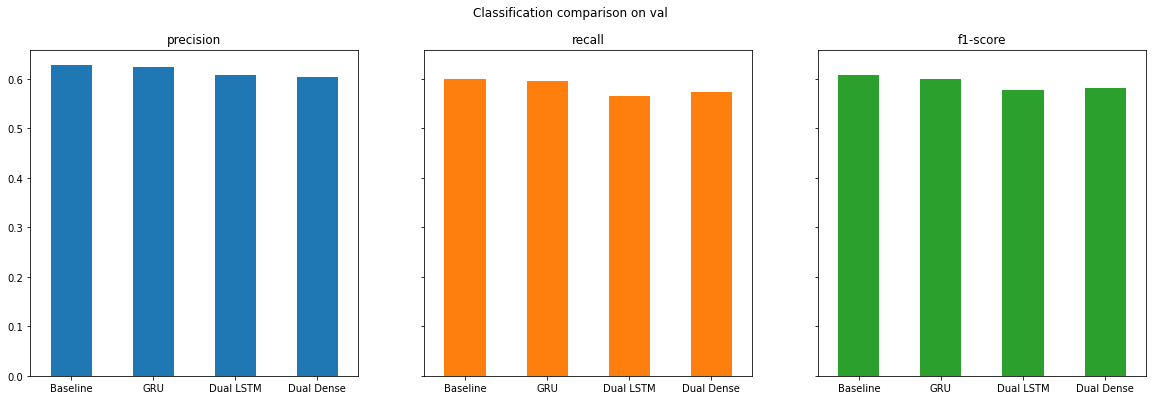

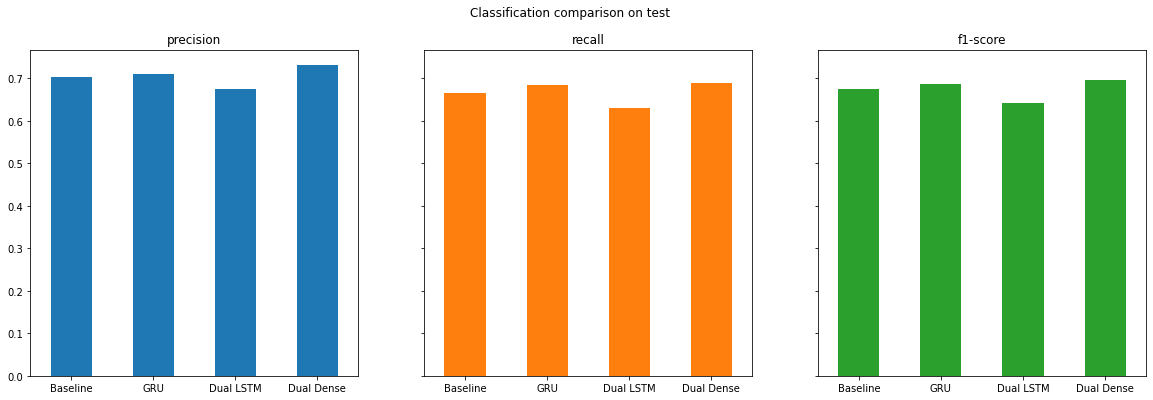

In [147]:
def plot_histogram(df: pd.DataFrame, names: typing.List[str]):
    for name in names:
        df_histogram = df.apply(
            lambda x: pd.Series({**x[f"classification_report_{name}"]["macro avg"]}),
            axis=1,
        )

        df_histogram.plot.bar(
            y=["precision", "recall", "f1-score"],
            legend=False,
            subplots=True,
            sharey=True,
            layout=(1, 3),
            figsize=(20, 6),
            rot=0,
            xlabel="",
            title=f"Classification comparison on {name}",
        )


plot_histogram(df_cr_no_punct, ["val", "test"])

Metrics that are usually computed like the R2, the MSE and the MAE are not useful in this situation: as a matter of fact, tags are assigned a number just for convenience purposes, but this does not mean that there is a "distance" between tags. 

The classic metrics like R2, MSE and MAE would implicitly assume that a distance between two tags can be computed, and that this would be equal to the absolute difference of the numerical representations of the tags, but this wouldn't make any sense. Suppose that a word should be classified with a tag $T$: the gravity of the error does not change if the word is misclassified with a tag $T' \neq T$, regardless of $T'$ and $T$.

### Bars of macro averages of precision, recall and f1-score among tags

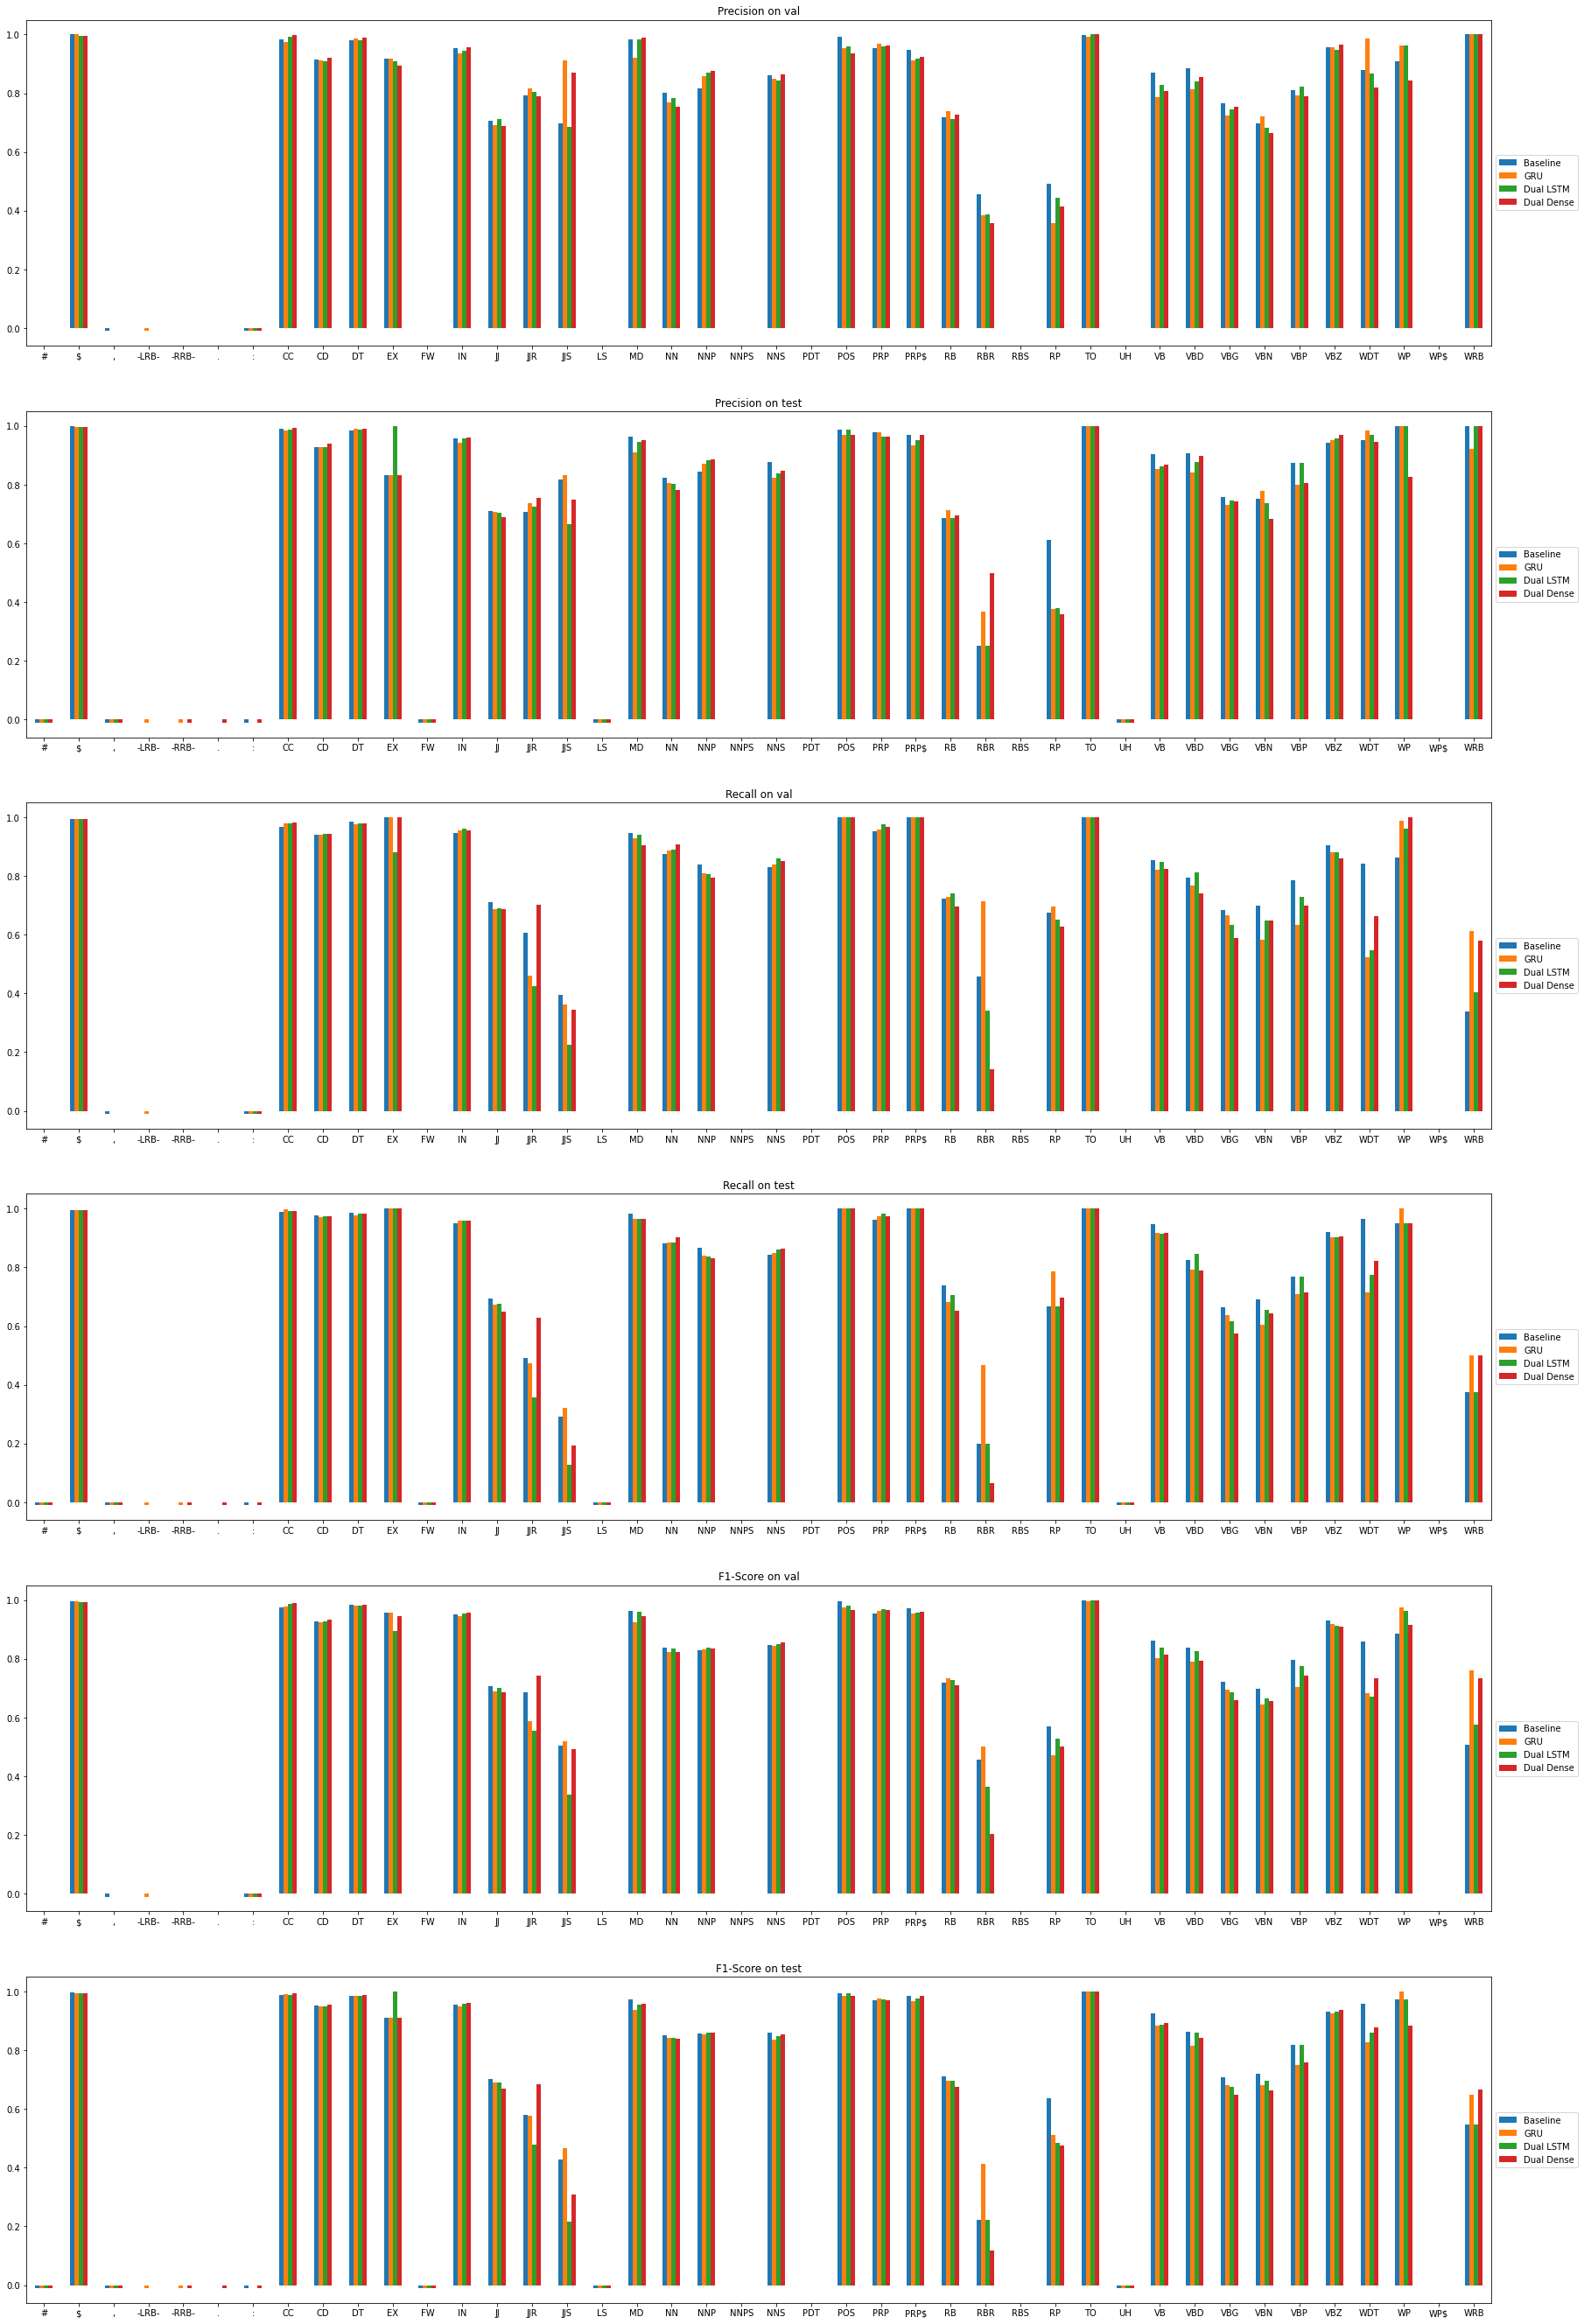

In [148]:
def tags_transformation(ser: pd.Series, name: str, metric: str, all_tags: typing.Set[str]) -> pd.Series:
    drop_columns = ["", "accuracy", "macro avg", "weighted avg"]
    s = pd.Series({**ser[f"classification_report_{name}"]})
    s = s.reindex(sorted(all_tags), axis=1)
    return s.drop(drop_columns).map(lambda x: x[metric], na_action="ignore")


def plot_tags_histograms(df: pd.DataFrame, names: typing.List[str]):
    all_tags = set(df.applymap(lambda x: list(x.keys())).agg(np.concatenate).agg(np.concatenate))
    metrics = ["precision", "recall", "f1-score"]

    total_num = len(metrics) * len(names)
    fig, axs = plt.subplots(total_num, figsize=(30, 8 * total_num))
    faxs = axs.ravel()
    i = 0

    for metric in metrics:
        for name in names:
            df_tmp = df.apply(tags_transformation, axis=1, args=(name, metric, all_tags))
            df_tmp.fillna(-0.01, inplace=True)
            # df_tmp.rename(index=df["name"], inplace=True)

            df_t = df_tmp.transpose()    
            df_t.plot.bar(ax=faxs[i], title=f"{metric.title()} on {name}", legend={"reverse"}, rot=0)
            faxs[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

            i += 1

    fig.show()

plot_tags_histograms(df_cr_no_punct, ["val", "test"])

Small note: the "negative" scores are just symbolic, and are meant to distinguish tags for which a score does not exist from tags whose score is actually 0. This has been done since there is some small discrepancy between the set of predicted tags across models (for example, some predict sometimes the tag corresponding to ":" whereas some others do not at all).

## Error analysis

From the metrics, we can see that the results obtained in the validation set are coherent with the results on the test set. By "coherent", we mean that:

- Whenever a score (e.g. F1 score) is high for a single tag in the test set, the same holds for the same tag in the validation set (when the supports of the given tag are sufficiently close in both sets). This can be easily confirmed by looking at the classification reports.
- The classification capabilities of the models are very similar: we can quickly judge it by comparing the graphical representations of the confusion matrices generated from the performances of the models in the test set and in the validation set (whenever the supports of the given tag is sufficiently close in both sets, which can be seen again in the classification reports).

Since the results are coherent, we can just inspect the results obtained in the test set. We can observe in many ways that a lot of classes are correctly recognized most of the time. We want to inspect and hopefully give an explanation as for why some classes are not.

In [ ]:
def print_top_results(
    ser: pd.Series, n_tags: int, reverse = False
):
    name = "test"
    drop_columns = ["", "accuracy", "macro avg", "weighted avg"]
    metric = "f1-score"

    cp = {**ser[f"classification_report_{name}"]}
    metric_tags = [
        (k, round(v["f1-score"], 3)) for k, v in cp.items() if k not in drop_columns
    ]
    metric_tags.sort(key=lambda x: x[1], reverse=reverse)

    print(f"{ser.name}: {metric_tags[:n_tags]}")


print("---Worst classified tags---")
_ = df_cr_no_punct.apply(print_top_results, axis=1, n_tags=10)

print("\n\n---Best classified tags---")
_ = df_cr_no_punct.apply(print_top_results, axis=1, n_tags=10, reverse=True)

All models appear to behave very similarly even at the level of the tags. Many tags are classified either badly or well by all the models. 

Since the models have different architectures behind, it's reasonable to think that the reason lies before the model itself: the training set. 

We have plotted some histograms about the distribution of the classes. We can use those to look for an explanation as for why some tags are better classified than others. 

Let's compare for example the distribution of the tag "NNPS" (Proper noun, plural), badly classified by every model, and the tag "PRP\$" (Possessive pronoun), which is instead perfectly classified by all the models.

In [ ]:
tags_all.head()

In [ ]:
tag1 = "NNPS"
tag2 = "PRP$"

tags_all[(tags_all["tags"] == tag1) | (tags_all["tags"] == tag2)][["tags", "train_counts"]]

On one hand, it certainly explains why all the models perform better in classifying the "PRP\$" tag rather than the "NNPS" tag, but this doesn't entirely capture the complexity of the situation. A hint is given by the fact that there are other tags with many more "examples" that, however, the model is not able to classify as well as "PRP\$". One such example is, trivially, the tag with the maximum number of examples:

In [ ]:
tags_all[tags_all["train_counts"] == tags_all["train_counts"].max()][
    ["tags", "train_counts"]
]

### Noun, singular or mass

NN is the name of the tag used to classify the following: "Noun, singular or mass".

This could give another hint as for why this tag requires more effort in order to be recognized correctly, even though there are a lot more examples: there are a lot of possible names, whereas the number of possessive pronouns is very limited. 

Clearly, other factors may affect the assigned tag to a certain token: after all, the models are very complex and also take into account the tokens around (usually referred to as "context") and their order in both directions. 

Just to peek at the reason of this apparent discrepancy, rather than considering the total number of examples, we should evaluate the total number of unique examples that can be found both in the training set and in the test set out of the total number unique examples that can be found in the test set. 

A ratio close to 1 should correlate to good performances, and a small set of possible values should push the ratio towards 1 more easily.

In [ ]:
def restrict_words(ser: pd.Series, tag: str):
    text_s, text_t = ser["text"].split(" "), ser["tags"].split(" ")
    return np.array(text_s)[np.array(text_t) == tag]

def search_unique_words(df: pd.DataFrame, tag: str):
    return np.unique(df.apply(restrict_words, axis=1, tag=tag).agg(np.concatenate))

tag = "NN"
test_words = search_unique_words(df_test, tag)
train_words = search_unique_words(df_train, tag)
intersect_words = np.intersect1d(test_words, train_words, assume_unique=True)

print(f"Number of unique words tagged as '{tag}' in the test set: {test_words.size}")
print(f"Number of unique words tagged as '{tag}' in the training set: {train_words.size}")
print(f"Number of unique words tagged as '{tag}' can be found in both test set and train set: {intersect_words.size}")
print(f"Therefore, the ratio we're interested in is: {intersect_words.size/test_words.size:.2f}")

But since the models are way more complex than that and are not limited to memorizing examples and tagging according to it, we can reasonably expect higher performances.

### Possessive pronouns

We can repeat the exact same procedure for the possessive pronouns:

In [ ]:
tag = "PRP$"
test_words = search_unique_words(df_test, tag)
train_words = search_unique_words(df_train, tag)
intersect_words = np.intersect1d(test_words, train_words, assume_unique=True)

print(f"Number of unique words tagged as '{tag}' in the test set: {test_words.size}")
print(f"Number of unique words tagged as '{tag}' in the training set: {train_words.size}")
print(f"Number of unique words tagged as '{tag}' can be found in both test set and train set: {intersect_words.size}")
print(f"Therefore, the ratio we're interested in is: {intersect_words.size/test_words.size:.2f}")

Which explains the discrepancy we've observed.

### Removing punctuation

Now, as an extra, we wanted to investigate in which way removing the punctuation influences the results. 

By following the same reasoning done to explain the discrepancy between class frequency and class labeling performances, we can conjecture that, by including the punctuation signs, the scores should improve (because we would now consider more tags that are very likely to be correctly identified). 

In order to confirm our suspicions, we just compute again the metrics that have been computed before, without removing the tags associated with punctuation beforehand.

In [ ]:
punct_path = os.path.join(os.getcwd(), "df_model_punct.pkl")
if os.path.exists(punct_path):
    df_punct = pd.read_pickle(punct_path)
else:
    trained_models = {
        "Baseline": baseline_model,
        "GRU": gru_model,
        "Dual LSTM": dual_lstm_model,
        "Dual Dense": dual_dense_model,
    }
    df_punct = create_models_dataframe(val_ds, test_ds, trained_models, decode_labels)
    df_punct.to_pickle(punct_path)

df_punct.head()

In [ ]:
df_cr_punct = df_punct.apply(lambda x: compute_classification_report(x), axis=1).rename(index=df_punct["name"])

assert isinstance(df_cr_punct, pd.DataFrame)

In [ ]:
def print_compare_metric(ser: pd.Series, metric: str):
    rename_fun = lambda x: (x, "_".join([metric] + x.rsplit("_", maxsplit=2)[-2:]))
    return ser.apply(lambda x: x['macro avg'][metric]).rename(dict(map(rename_fun, list(ser.index))))

# print_metric([df_cr_punct, ["val", "test"], "f1-score")
df_cr_punct.join(df_cr_no_punct, lsuffix="_punct", rsuffix="_no_punct").apply(print_compare_metric, axis=1, metric="f1-score").head()